In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import PIL.Image
from pathlib import Path
import torchvision

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import json
import time
import timm

In [2]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
nfolds = 4
fname = 'resnet50'
IMAGE_DIR = '/kaggle/input/panda-16x128x128-tiles-data/train'
LABELS = '/kaggle/input/prostate-cancer-grade-assessment/train.csv'
SEED = 2024

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
loss_name = "mse"
TRAIN_DATASET_FRAC = 1
num_epochs = 20
EARLY_STOPPING = True
MIN_EPOCH = 10
PATIENCE = 8

## Seed everything

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

## Dataset class

In [5]:
class ProstateTilesDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_dir, n_tiles=(3, 4), transform=None):
        self.df = df
        self.image_dir = image_dir
        self.n_tiles = n_tiles  
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id = row.image_id
        label = row.isup_grade
        tile_rows, tile_cols = self.n_tiles
        imgs = []
        for i in range(tile_rows):
            for j in range(tile_cols):
                img_path = Path(self.image_dir, f'{img_id}_{i * tile_cols + j}.png')
                img = PIL.Image.open(img_path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                imgs.append(img)
        imgs = torch.stack(imgs) # (12, 3, 128, 128)
        return imgs, label

## Model

In [6]:
class CustomPool(nn.Module):
    def __init__(self, N=12):
        super(CustomPool, self).__init__()
        self.avg_pool = nn.AvgPool1d(kernel_size=N)
        self.max_pool = nn.MaxPool1d(kernel_size=N)

    def forward(self, x):
        # x = (BS, 12, 2048)
        x = x.transpose(1, 2)  # (BS, 512, 12)
        avg_pooled = self.avg_pool(x).squeeze(-1)  # (BS, 512)
        max_pooled = self.max_pool(x).squeeze(-1)  # (BS, 512)
        concatenated_features = torch.cat((avg_pooled, max_pooled), dim=1)  # (BS, 512*2)
        return concatenated_features

In [7]:
class Model(nn.Module):
    def __init__(self, num_classes=1): # change back to 6
        super().__init__()
        self.enc = timm.create_model('resnet50.a1_in1k', pretrained=True, num_classes=0)
        
        
        nc = self.enc.feature_info[-1]['num_chs']
        self.pool = CustomPool()
        self.head = nn.Sequential(
            nn.Linear(nc*2,512), # (BS, 12, 512)
            nn.Mish(),
            nn.Dropout(0.25),
            nn.Linear(512,num_classes)
        )
        
    def forward(self, x):
        # x = (BS, 12, 3, 128, 128)
        n = x.shape[1]
        x = x.view(-1, x.shape[2], x.shape[3], x.shape[4]) # (BS*12, 3, 128, 128)
        x = self.enc(x) # (BS*12, nc)
        x = x.view(-1,n,x.shape[1]) # (BS, 12, nc)
        x = self.pool(x) # (BS, 512*2)
        x = self.head(x)
        return x

## Training utility functions

In [8]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    start_time = time.time()
    with tqdm(
        dataloader,
        desc=(f"Epoch {epoch} - Train"),
        unit=" slide",
        unit_scale=BATCH_SIZE,
        leave=False,
    ) as t:
        for inputs, labels in t:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float()
            outputs = model(inputs)
            if loss_name == "mse":
                loss = criterion(outputs.squeeze(-1), labels)
            else:
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
    
    average_loss = total_loss / len(dataloader)
    end_time = time.time()
    return average_loss

In [9]:
def go_from_mse_logit_to_prediction(logit):
    if logit < 0.5:
        return 0
    elif logit < 1.5:
        return 1
    elif logit < 2.5:
        return 2
    elif logit < 3.5:
        return 3
    elif logit < 4.5:
        return 4
    else:
        return 5

In [10]:
def tune(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    start_time = time.time()
    with tqdm(
        dataloader,
        desc=(f"Epoch {epoch} - Tune"),
        unit=" slide",
        unit_scale=BATCH_SIZE,
        leave=False,
    ) as t:
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.float()
                outputs = model(inputs)
                if loss_name == "mse":
                    loss = criterion(outputs.squeeze(-1), labels)
                else:
                    loss = criterion(outputs, labels)
                total_loss += loss.item()
                if loss_name == "mse":
                    preds = [go_from_mse_logit_to_prediction(o) for o in outputs]
                else:
                    preds = outputs.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

    average_loss = total_loss / len(dataloader)
    end_time = time.time()  
    elapsed_time = end_time - start_time 
    kappa = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    return average_loss, kappa, all_preds, all_labels

In [11]:
def log_metrics(epoch, fold, train_loss, tune_loss, kappa):
    logs = {'epoch': epoch, 'fold': fold, 'train_loss': train_loss, 'tune_loss': tune_loss, 'kappa': kappa}
    logs_folder = Path("/kaggle/working/logs")
    logs_folder.mkdir(exist_ok=True)
    log_file = Path(logs_folder, f'log_{fname}_{fold}.json')
    if log_file.is_file():
        with open(log_file, 'r') as file:
            data = json.load(file)
    else:
        data = []
    data.append(logs)
    with open(log_file, 'w') as file:
        json.dump(data, file)

In [12]:
def save_best_model(model, best_val, current_val, fold, epoch, min_max="min"):
    improve_flag = False
    if min_max == "max":
        best_val = -1 * best_val
        current_val = -1 * current_val
    if current_val < best_val:
        improve_flag = True
        best_val = current_val
        torch.save(model.state_dict(), f'{fname}_{fold}.pth')
        print(f"Saved better model for fold {fold} at epoch {epoch}")
    if min_max == "max":
        best_val = -1 * best_val
    return best_val, improve_flag

## Model training

In [13]:
df = pd.read_csv(LABELS)
df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [14]:
# grab slide ids in /kaggle/input/panda-16x128x128-tiles-data
slide_ids = list(set([fp.stem.split("_")[0] for fp in Path(IMAGE_DIR).glob("*.png")]))
len(slide_ids)

10516

In [15]:
# restrict previous dataframe to those ids
df_restricted = df[df.image_id.isin(slide_ids)].reset_index(drop=True)
len(df) - len(df_restricted)

100

In [16]:
skf = StratifiedKFold(n_splits=nfolds, random_state=SEED, shuffle=True)
X = df_restricted.image_id.values
y = df_restricted.isup_grade.values
train_dfs, tune_dfs = [], []
for i, (train_index, tune_index) in enumerate(skf.split(X, y)):
    train_df, tune_df = df_restricted.loc[train_index], df_restricted.loc[tune_index]
    if TRAIN_DATASET_FRAC < 1.0:
        train_df = train_df.sample(frac=TRAIN_DATASET_FRAC, random_state=SEED)
    train_df = train_df.reset_index(drop=True)
    tune_df = tune_df.reset_index(drop=True)
    train_dfs.append(train_df)
    tune_dfs.append(tune_df)
    print(f"fold {i+1}/{nfolds}: train={len(train_df)}, tune={len(tune_df)}")

fold 1/4: train=7887, tune=2629
fold 2/4: train=7887, tune=2629
fold 3/4: train=7887, tune=2629
fold 4/4: train=7887, tune=2629


In [17]:
mean = torch.tensor([1.0-0.90949707, 1.0-0.8188697, 1.0-0.87795304])
std = torch.tensor([0.36357649, 0.49984502, 0.40477625])

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    
    # more augmentations (added): 
    transforms.RandomResizedCrop(size=int(0.85*IMAGE_SIZE)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=[-0.03,0.04]),

    
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    
])

In [18]:
def show_image(img_tensor, title):
    img = img_tensor.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [20]:
all_folds_preds = []
all_folds_labels = []
for fold in range(nfolds):

    train_dataset = ProstateTilesDataset(train_dfs[fold], IMAGE_DIR, transform=transform)
    tune_dataset = ProstateTilesDataset(tune_dfs[fold], IMAGE_DIR, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    tune_loader = torch.utils.data.DataLoader(tune_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    
    if loss_name == "mse":
        num_classes =  1
        criterion = nn.MSELoss()
    else:
        num_classes = 6
        criterion = nn.CrossEntropyLoss()
        
    model = Model(num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_kappa = -np.inf
    best_loss = np.inf
    best_fold_dict = {
            "epochs": [None] * num_epochs,
            "kappa": [None] * num_epochs,
            "preds": [None] * num_epochs,
            "labels": [None] * num_epochs,
            "loss": [float('inf')] * num_epochs
        }


    
    early_stopping_count = 0
    
    with tqdm(
        range(num_epochs),
        desc=f"Fold {fold+1}/{nfolds}",
        unit=" epoch",
        leave=True,
    ) as t:
        for epoch in t:
            train_loss = train(model, train_loader, criterion, optimizer, device)
            tqdm.write(f"Epoch {epoch} - train_loss: {train_loss:.4f}")
            valid_loss, kappa, fold_preds, fold_labels = tune(model, tune_loader, criterion, device)
            tqdm.write(f"Epoch {epoch} - tune loss: {valid_loss:.4f}")
            tqdm.write(f"Epoch {epoch} - tune kappa: {kappa:.4f}")
            log_metrics(epoch, fold, train_loss, valid_loss, kappa)
        
            best_fold_dict["epochs"][epoch] = (epoch + 1)
            best_fold_dict["kappa"][epoch] = kappa
            best_fold_dict["preds"][epoch] = fold_preds
            best_fold_dict["labels"][epoch] = fold_labels
            best_fold_dict["loss"][epoch] = valid_loss

            
            # best_kappa, improve_flag = save_best_model(model, best_kappa, kappa, fold, epoch, min_max="max")
            best_loss, improve_flag = save_best_model(model, best_loss, valid_loss, fold, epoch,  min_max="min")
            if not improve_flag:
                early_stopping_count += 1
            if EARLY_STOPPING and early_stopping_count > PATIENCE and epoch >= MIN_EPOCH:
                print(f"Epoch {epoch} - Stopping early as model didn't improve over the last {PATIENCE} epochs")
                break
    
    
    # get best epoch based on lowest loss
    min_value_index = best_fold_dict['loss'].index(min(best_fold_dict['loss']))
    best_epoch = best_fold_dict['epochs'][min_value_index]
    loss_best = best_fold_dict['loss'][min_value_index]
    print(f'Best performing epoch of fold {fold +1} is {best_epoch} with a loss of {loss_best}')

    all_folds_preds.extend(best_fold_dict["preds"][min_value_index])
    all_folds_labels.extend(best_fold_dict["labels"][min_value_index])
    

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Fold 1/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 1.9969


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.8295
Epoch 0 - tune kappa: 0.5800
Saved better model for fold 0 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.5824


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.4464
Epoch 1 - tune kappa: 0.6393
Saved better model for fold 0 at epoch 1


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.4617


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.6653
Epoch 2 - tune kappa: 0.5508


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.4032


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.4467
Epoch 3 - tune kappa: 0.6811


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 1.3868


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.4085
Epoch 4 - tune kappa: 0.7178
Saved better model for fold 0 at epoch 4


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 1.3112


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.5993
Epoch 5 - tune kappa: 0.5958


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 1.3268


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 2.1857
Epoch 6 - tune kappa: 0.5600


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 1.2783


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.3369
Epoch 7 - tune kappa: 0.6862
Saved better model for fold 0 at epoch 7


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 1.2476


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.4357
Epoch 8 - tune kappa: 0.6097


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 1.2321


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.5413
Epoch 9 - tune kappa: 0.6828


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 1.2245


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.6429
Epoch 10 - tune kappa: 0.6369


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 1.2105


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.5107
Epoch 11 - tune kappa: 0.6750


Epoch 12 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 1.2082


Epoch 12 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.4409
Epoch 12 - tune kappa: 0.6643
Epoch 12 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 1 is 8 with a loss of 1.3369121415069305


Fold 2/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 1.9796


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 2.0972
Epoch 0 - tune kappa: 0.4654
Saved better model for fold 1 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.5531


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 2.3685
Epoch 1 - tune kappa: 0.5563


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.4815


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.6304
Epoch 2 - tune kappa: 0.5532
Saved better model for fold 1 at epoch 2


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.3804


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.3888
Epoch 3 - tune kappa: 0.6840
Saved better model for fold 1 at epoch 3


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 1.3823


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.4826
Epoch 4 - tune kappa: 0.6482


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 1.3442


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.4450
Epoch 5 - tune kappa: 0.6674


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 1.2948


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.7142
Epoch 6 - tune kappa: 0.6608


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 1.2672


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.3314
Epoch 7 - tune kappa: 0.7153
Saved better model for fold 1 at epoch 7


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 1.2876


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.5463
Epoch 8 - tune kappa: 0.6795


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 1.2429


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.2572
Epoch 9 - tune kappa: 0.6905
Saved better model for fold 1 at epoch 9


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 1.2322


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.2820
Epoch 10 - tune kappa: 0.7332


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 1.2211


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.4902
Epoch 11 - tune kappa: 0.6759


Epoch 12 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 1.1789


Epoch 12 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.4449
Epoch 12 - tune kappa: 0.6776


Epoch 13 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 13 - train_loss: 1.1785


Epoch 13 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 13 - tune loss: 1.5817
Epoch 13 - tune kappa: 0.6274
Epoch 13 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 2 is 10 with a loss of 1.25724660632122


Fold 3/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 1.9806


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.6652
Epoch 0 - tune kappa: 0.6207
Saved better model for fold 2 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.6178


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.8385
Epoch 1 - tune kappa: 0.5232


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.4830


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.9599
Epoch 2 - tune kappa: 0.5384


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.4258


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.9961
Epoch 3 - tune kappa: 0.4961


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 1.4003


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.4242
Epoch 4 - tune kappa: 0.6634
Saved better model for fold 2 at epoch 4


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 1.3164


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.4061
Epoch 5 - tune kappa: 0.6765
Saved better model for fold 2 at epoch 5


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 1.3246


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.3687
Epoch 6 - tune kappa: 0.7013
Saved better model for fold 2 at epoch 6


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 1.2835


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.3536
Epoch 7 - tune kappa: 0.7330
Saved better model for fold 2 at epoch 7


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 1.2761


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.6102
Epoch 8 - tune kappa: 0.6337


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 1.2045


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.6680
Epoch 9 - tune kappa: 0.5859


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 1.2611


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.2915
Epoch 10 - tune kappa: 0.7183
Saved better model for fold 2 at epoch 10


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 1.2057


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.6412
Epoch 11 - tune kappa: 0.6753


Epoch 12 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 1.2137


Epoch 12 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.2806
Epoch 12 - tune kappa: 0.7256
Saved better model for fold 2 at epoch 12


Epoch 13 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 13 - train_loss: 1.1641


Epoch 13 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 13 - tune loss: 1.9279
Epoch 13 - tune kappa: 0.5828


Epoch 14 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 14 - train_loss: 1.1428


Epoch 14 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 14 - tune loss: 1.3850
Epoch 14 - tune kappa: 0.7038


Epoch 15 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 15 - train_loss: 1.1267


Epoch 15 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 15 - tune loss: 1.3022
Epoch 15 - tune kappa: 0.7227
Epoch 15 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 3 is 13 with a loss of 1.2806149994034366


Fold 4/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 1.9595


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 2.1017
Epoch 0 - tune kappa: 0.5067
Saved better model for fold 3 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.5489


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.6339
Epoch 1 - tune kappa: 0.6505
Saved better model for fold 3 at epoch 1


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.4880


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.3587
Epoch 2 - tune kappa: 0.6899
Saved better model for fold 3 at epoch 2


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.4249


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.3479
Epoch 3 - tune kappa: 0.7259
Saved better model for fold 3 at epoch 3


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 1.3556


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.4963
Epoch 4 - tune kappa: 0.6337


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 1.3533


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.5354
Epoch 5 - tune kappa: 0.5859


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 1.3331


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.4814
Epoch 6 - tune kappa: 0.6735


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 1.3022


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.4355
Epoch 7 - tune kappa: 0.6922


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 1.2669


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.4016
Epoch 8 - tune kappa: 0.6947


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 1.2518


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.3447
Epoch 9 - tune kappa: 0.7109
Saved better model for fold 3 at epoch 9


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 1.2378


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.4907
Epoch 10 - tune kappa: 0.6876


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 1.2181


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.5221
Epoch 11 - tune kappa: 0.7213


Epoch 12 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 1.2029


Epoch 12 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.4400
Epoch 12 - tune kappa: 0.6818


Epoch 13 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 13 - train_loss: 1.1803


Epoch 13 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 13 - tune loss: 1.2161
Epoch 13 - tune kappa: 0.7323
Saved better model for fold 3 at epoch 13


Epoch 14 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 14 - train_loss: 1.1685


Epoch 14 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 14 - tune loss: 1.2514
Epoch 14 - tune kappa: 0.7396
Epoch 14 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 4 is 14 with a loss of 1.216087763927069


Overall CV Score: 0.7096


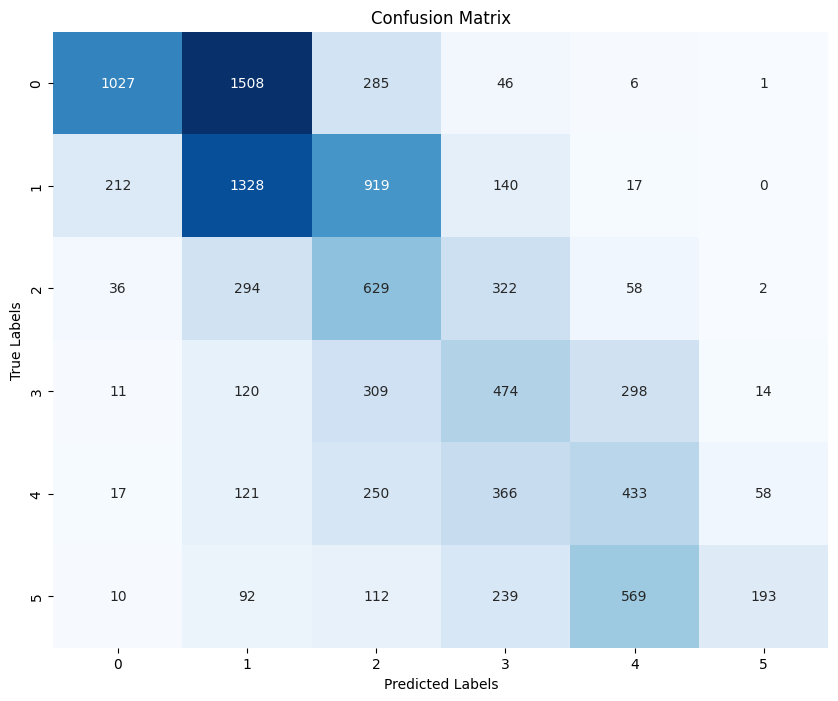

In [21]:
preds_array = np.array(all_folds_preds)
labels_array = np.array(all_folds_labels)

kappa_score = cohen_kappa_score(labels_array, preds_array, weights='quadratic')
print(f"Overall CV Score: {kappa_score:.4f}")

cm = confusion_matrix(labels_array, preds_array)

plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### Plot loss curves 

In [22]:
# with open(f'/kaggle/working/logs/log_{fname}_0.json') as f:
#     d = json.load(f)
#     epoch = []
#     train_loss = []
#     tune_loss = []
#     kappa = []
#     for sd in d:
#         epoch.append(sd['epoch'])
#         train_loss.append(sd['train_loss'])
#         tune_loss.append(sd['tune_loss'])
#         kappa.append(sd['kappa'])

In [23]:
# import matplotlib.pyplot as plt

# plt.figure(dpi=100)
# plt.plot(train_loss, label='train', color="#59A9D4")
# plt.plot(tune_loss, label='tune', color="#D459C1")

# plt.title('Loss', pad=10)
# plt.xlabel('epoch', labelpad=10)
# plt.ylabel('loss', labelpad=10)
# plt.xticks(range(len(train_loss)), range(1, len(train_loss)+1))  # Assuming epochs start at 1
# plt.legend()
# plt.tight_layout()
# plt.show()

{'epoch': 0, 'fold': 0, 'train_loss': 1.9969461159667505, 'tune_loss': 1.829504092055631, 'kappa': 0.5800213165235649}
{'epoch': 1, 'fold': 0, 'train_loss': 1.5824392264188543, 'tune_loss': 1.446351965507829, 'kappa': 0.6393477644990119}
{'epoch': 2, 'fold': 0, 'train_loss': 1.4616682416031719, 'tune_loss': 1.6652808203754654, 'kappa': 0.5508373709439686}
{'epoch': 3, 'fold': 0, 'train_loss': 1.4032486764042966, 'tune_loss': 1.4467236133943122, 'kappa': 0.6810854849597192}
{'epoch': 4, 'fold': 0, 'train_loss': 1.3868431716795393, 'tune_loss': 1.408466031752437, 'kappa': 0.7177647219630789}
{'epoch': 5, 'fold': 0, 'train_loss': 1.3112043792660903, 'tune_loss': 1.5993400144289776, 'kappa': 0.5958495946771516}
{'epoch': 6, 'fold': 0, 'train_loss': 1.326805169765766, 'tune_loss': 2.1856643018952333, 'kappa': 0.5599723459319941}
{'epoch': 7, 'fold': 0, 'train_loss': 1.2782701936810605, 'tune_loss': 1.3369121415069305, 'kappa': 0.6861669131091502}
{'epoch': 8, 'fold': 0, 'train_loss': 1.2476

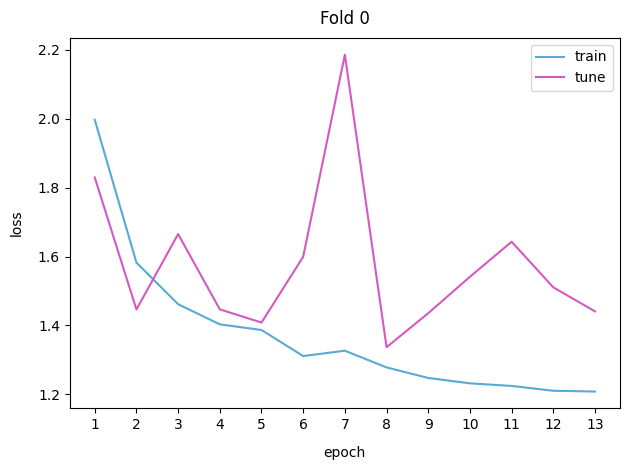

{'epoch': 0, 'fold': 1, 'train_loss': 1.9795779769237225, 'tune_loss': 2.097177890409906, 'kappa': 0.46536207104569816}
{'epoch': 1, 'fold': 1, 'train_loss': 1.5531106615356105, 'tune_loss': 2.368534606623362, 'kappa': 0.5563181676542923}
{'epoch': 2, 'fold': 1, 'train_loss': 1.481516533535019, 'tune_loss': 1.6303992249879493, 'kappa': 0.5531853156697006}
{'epoch': 3, 'fold': 1, 'train_loss': 1.3803528601582717, 'tune_loss': 1.3888189742364079, 'kappa': 0.6839837196435272}
{'epoch': 4, 'fold': 1, 'train_loss': 1.3823341336327526, 'tune_loss': 1.482632603271898, 'kappa': 0.6482197136246375}
{'epoch': 5, 'fold': 1, 'train_loss': 1.344241936921108, 'tune_loss': 1.445000886198986, 'kappa': 0.6674379158484428}
{'epoch': 6, 'fold': 1, 'train_loss': 1.2948397826327969, 'tune_loss': 1.7141863258488208, 'kappa': 0.6607749288860926}
{'epoch': 7, 'fold': 1, 'train_loss': 1.2672323553185714, 'tune_loss': 1.3313909934227726, 'kappa': 0.7152596630758297}
{'epoch': 8, 'fold': 1, 'train_loss': 1.28762

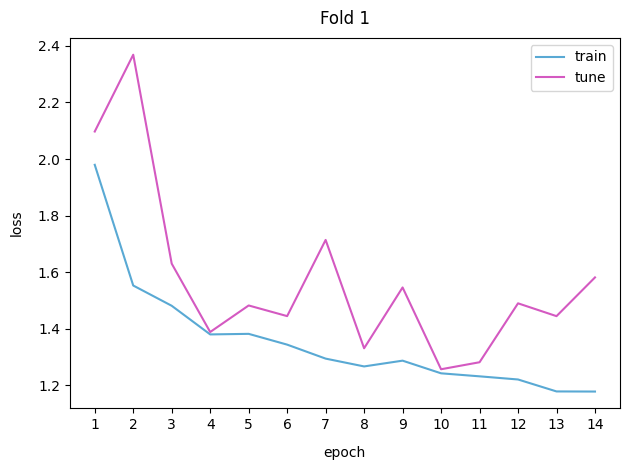

{'epoch': 0, 'fold': 2, 'train_loss': 1.9806375221202248, 'tune_loss': 1.6652384960507771, 'kappa': 0.6206880308042402}
{'epoch': 1, 'fold': 2, 'train_loss': 1.6177622762768857, 'tune_loss': 1.8385196005005435, 'kappa': 0.523207708283159}
{'epoch': 2, 'fold': 2, 'train_loss': 1.4829997432376691, 'tune_loss': 1.9599484047257756, 'kappa': 0.5384058366985205}
{'epoch': 3, 'fold': 2, 'train_loss': 1.4258030083498008, 'tune_loss': 1.9961070296276047, 'kappa': 0.49609551031192567}
{'epoch': 4, 'fold': 2, 'train_loss': 1.4003077397944956, 'tune_loss': 1.424172856003405, 'kappa': 0.6633640850738898}
{'epoch': 5, 'fold': 2, 'train_loss': 1.316369280520721, 'tune_loss': 1.4060786280287318, 'kappa': 0.676533675038667}
{'epoch': 6, 'fold': 2, 'train_loss': 1.3245611655326024, 'tune_loss': 1.368675304464547, 'kappa': 0.7012648903625011}
{'epoch': 7, 'fold': 2, 'train_loss': 1.2834717685635757, 'tune_loss': 1.3535786895866853, 'kappa': 0.732952670156665}
{'epoch': 8, 'fold': 2, 'train_loss': 1.27607

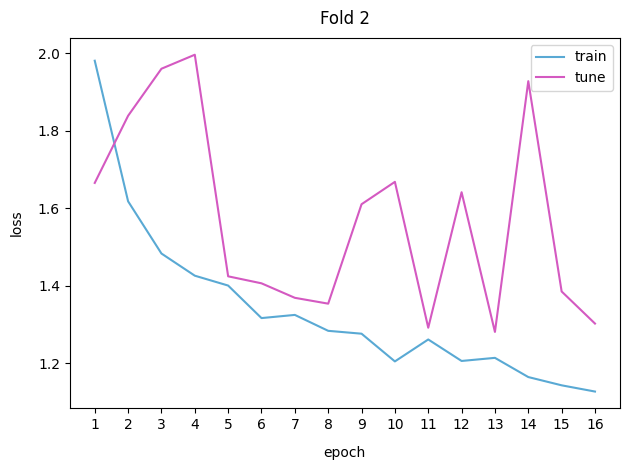

{'epoch': 0, 'fold': 3, 'train_loss': 1.959544869087003, 'tune_loss': 2.1017468837370354, 'kappa': 0.5066907309291084}
{'epoch': 1, 'fold': 3, 'train_loss': 1.5489173749921776, 'tune_loss': 1.6339469832110118, 'kappa': 0.6504535847618643}
{'epoch': 2, 'fold': 3, 'train_loss': 1.4879731519019554, 'tune_loss': 1.3586848439222359, 'kappa': 0.6898827684375117}
{'epoch': 3, 'fold': 3, 'train_loss': 1.4248864585571444, 'tune_loss': 1.3478664913809444, 'kappa': 0.7259415200582051}
{'epoch': 4, 'fold': 3, 'train_loss': 1.3556429253898652, 'tune_loss': 1.4963017271225711, 'kappa': 0.6337018660625495}
{'epoch': 5, 'fold': 3, 'train_loss': 1.3533346513022295, 'tune_loss': 1.5354337462459702, 'kappa': 0.5859459760381674}
{'epoch': 6, 'fold': 3, 'train_loss': 1.333141072800285, 'tune_loss': 1.4814197564699563, 'kappa': 0.673478313859959}
{'epoch': 7, 'fold': 3, 'train_loss': 1.3021860962454606, 'tune_loss': 1.4354521230042698, 'kappa': 0.6922214872126218}
{'epoch': 8, 'fold': 3, 'train_loss': 1.266

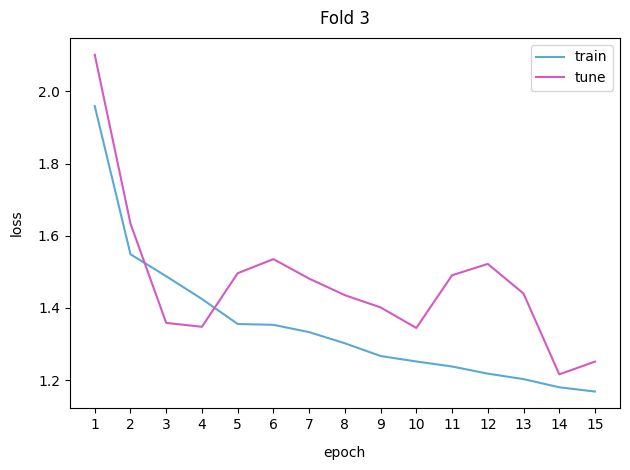

In [24]:
import matplotlib.pyplot as plt

for fold in range(nfolds):
    with open(f'/kaggle/working/logs/log_{fname}_{fold}.json') as f:
        d = json.load(f)
        epoch = []
        train_loss = []
        tune_loss = []
        kappa = []
        for sd in d:
            print(sd)
            epoch.append(sd['epoch'])
            train_loss.append(sd['train_loss'])
            tune_loss.append(sd['tune_loss'])
            kappa.append(sd['kappa'])

    

    plt.figure(dpi=100)
    plt.plot(train_loss, label='train', color="#59A9D4")
    plt.plot(tune_loss, label='tune', color="#D459C1")

    plt.title(f'Fold {fold}', pad=10)
    plt.xlabel('epoch', labelpad=10)
    plt.ylabel('loss', labelpad=10)
    plt.xticks(range(len(train_loss)), range(1, len(train_loss)+1))  # Assuming epochs start at 1
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'log_{fname}_{fold}.png')
    plt.show()